In [1]:
# Standard
import pandas as pd
import numpy as np
import pickle

# Time Cleaning
import time
import datetime
from dateutil.relativedelta import relativedelta

# Scraping
import requests
import locale
from pandas.io.json import json_normalize
import io

import os
from os.path import exists

import statsmodels.api as sm
from statsmodels import regression


import matplotlib.pyplot as plt

# Import User Defined functions
import source.read_tickers_and_isins as URTI
import source.get_directors_dealings as UGDD
import source.get_timeseries as UGT
import source.analyze_get_summary_of_data as AGSOD
import source.preprocess_directors_dealings as UPDD
import source.preprocess_timeseries as UPTS
import source.preprocess_timeseries_from_excel as UPTFE
import source.analyse_single_company as UASC
import source.calculate_daily_returns_for_period as CDRFP
from tqdm import tqdm


loading return series...


100%|██████████| 2171/2171 [00:03<00:00, 663.50it/s]


calculate returns
concatenate
            ReturnIndex  ReturnIndex  ReturnIndex  ReturnIndex  ReturnIndex  \
Date                                                                          
2016-03-21          NaN          NaN          NaN          NaN          NaN   
2016-03-22    -0.017093    -0.010389     0.000125     0.004231    -0.008025   
2016-03-23    -0.008830    -0.010381    -0.014121     0.006300    -0.024030   
2016-03-24    -0.005208     0.006365    -0.014704    -0.024222    -0.010666   
2016-03-25     0.000000     0.000468     0.000000     0.000000     0.000000   

            ReturnIndex  ReturnIndex  ReturnIndex  ReturnIndex  ReturnIndex  \
Date                                                                          
2016-03-21          NaN          NaN          NaN          NaN          NaN   
2016-03-22          NaN     0.000174     0.009428          NaN    -0.012487   
2016-03-23          NaN     0.000000    -0.011424          NaN    -0.037936   
2016-03-24          N

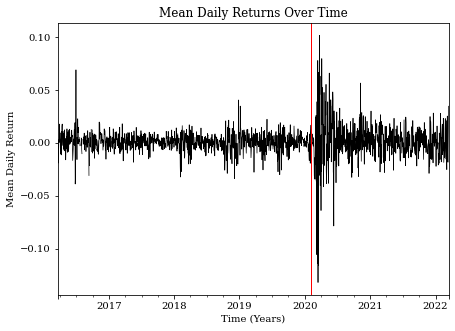

100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


In [2]:
NAME = "Niedermayer" # "Knudsen"
DATA_LOCATION = f'data/{NAME}/'
DATA_LOCATION_INSIDER_RAW = DATA_LOCATION + 'raw/insider/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_TIME_SERIES_RAW = DATA_LOCATION + 'raw/timeseries/'
DATA_LOCATION_TIME_SERIES_PROCESSED = DATA_LOCATION + 'processed/timeseries/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI/'

_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED


file_locs_ = os.listdir(_ri_location)
file_locs = [_ri_location + f for f in file_locs_]
return_index_dfs = []
isins = []
print("loading return series...")
for file_loc in tqdm(file_locs):
    with open(file_loc, "rb") as f:
        company = pickle.load(f)
    return_index_dfs.append(company.return_index_df)
    isins.append(company.isin)

company_return = return_index_dfs[0]

insider_data_df = pd.read_csv(_insider_location + company.ticker + '.csv', index_col=0, parse_dates=['FilingDate', 'TradeDate'])


print("calculate returns")
returns_df = [CDRFP.calculate_daily_returns(ts) for ts in return_index_dfs]

print("concatenate")
df_returns = pd.concat(returns_df[:10000], axis=1) # TODO remove the slice
df_return_index = pd.concat(return_index_dfs[:10], axis=1)

print(df_returns.head())

plt.rc('font', family='serif')
plt.rc('xtick')
plt.rc('ytick')

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

returns_companies = df_returns.mean(axis=1)
returns_companies.plot(color="k", linewidth=0.7)

ax.set_xlabel('Time (Years)')
ax.set_ylabel('Mean Daily Return')
ax.set_title('Mean Daily Returns Over Time')

interval_borders = ["2020-02-01"] # TODO see if it makes sense to actually take first of Feb
for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)

plt.savefig(DATA_LOCATION +"visualisations/NYSE_daily_returns.jpg", dpi=600)
plt.show()

pickles = os.listdir(DATA_LOCATION_RI)[:100] # TODO remove
ISINs = [rick[:-7] for rick in pickles]

outputs = []
for isin in tqdm(ISINs):
    outputs.append(UASC.analyse_single_company(isin, DATA_LOCATION_RI, DATA_LOCATION_INSIDER_PROCESSED))

sum_returns = sum([x[0] for x in outputs], [])
filing_trade_lags = sum([x[1] for x in outputs], [])



### Investigate Filing Trade Lag Times

Negative lag for 12 out of 29688 trades.
[   -7.54694444  -631.23416667 -1420.87166667 -1420.92777778
 -1779.69361111 -1779.70388889 -1779.7125     -1779.72444444
 -1876.34       -1876.375      -1876.405      -1876.58111111]


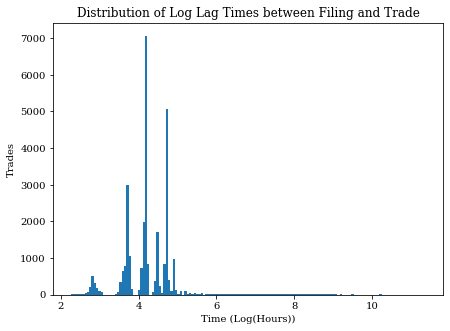

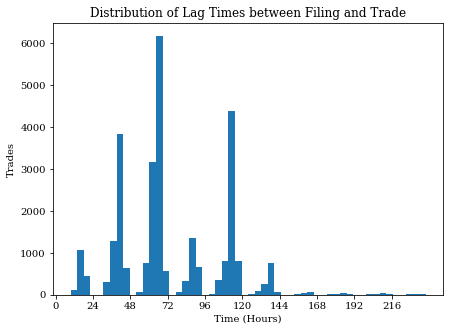

In [3]:
from matplotlib import pyplot as plt
import numpy as np

lag_in_hours = np.asarray(filing_trade_lags)
negative_lag_mask = lag_in_hours < 0
positive_lag = lag_in_hours[~negative_lag_mask]
print(f"Negative lag for {negative_lag_mask.sum()} out of {len(negative_lag_mask)} trades.")
print(lag_in_hours[negative_lag_mask])

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(np.log(positive_lag), bins="auto")
ax.set_xlabel('Time (Log(Hours))')
ax.set_ylabel('Trades')
ax.set_title('Distribution of Log Lag Times between Filing and Trade')

plt.savefig(DATA_LOCATION +"visualisations/log_transformed_lags.jpg", dpi=600)
plt.show()

without_outliers = positive_lag[positive_lag < 240]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(without_outliers, bins="auto")
plt.xticks(np.arange(0, max(without_outliers) + 1, 24))
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Trades')
ax.set_title('Distribution of Lag Times between Filing and Trade')

plt.savefig(DATA_LOCATION +"visualisations/lags_without_outliers.jpg", dpi=600)

# Get Market timeseries

In [4]:
end_time = datetime.datetime(2022, 3, 21, 23, 59, 59)
_end_time_unix = int(time.mktime(end_time.timetuple()))
print(_end_time_unix)

start_time = datetime.datetime(2016, 3, 21, 0, 0, 0)
_start_time_unix = int(time.mktime(start_time.timetuple()))

print(_start_time_unix)

if NAME == "Knudsen":
    _ticker = '%5EIXIC'
    
if NAME == "Niedermayer":
    _ticker = "%5Enya"
    #url = "input_data/Niedermayer/NYSE Composite Total Return Historical Data.csv"
    #market_timeseries = pd.read_csv(url, thousands=',')
    #market_timeseries["Date"] = pd.to_datetime(market_timeseries2["Date"])
    #market_timeseries = market_timeseries.set_index('Date')
    #market_timeseries.index = market_timeseries.index.astype('datetime64[ns]')
    #market_timeseries = market_timeseries[end_time:start_time] # sorted in descending order so it is sliced in this order
else:
    raise NotImplementedError
    
url = f'https://query1.finance.yahoo.com/v7/finance/download/{_ticker}?period1={_start_time_unix}&period2={_end_time_unix}&interval=1d&events=history&includeAdjustedClose=true'
market_timeseries = pd.read_csv(url)

market_timeseries = market_timeseries.set_index('Date')
market_timeseries.index = market_timeseries.index.astype('datetime64[ns]')


market_timeseries

1647903599
1458514800


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-21,10204.700195,10232.799805,10181.849609,10219.690430,10219.690430,3376600000
2016-03-22,10169.900391,10226.509766,10145.349609,10194.200195,10194.200195,3418460000
2016-03-23,10171.379883,10171.379883,10096.889648,10099.679688,10099.679688,3639510000
2016-03-24,10032.889648,10087.049805,10003.980469,10086.599609,10086.599609,3407720000
2016-03-28,10105.120117,10128.900391,10065.379883,10106.440430,10106.440430,2809090000
...,...,...,...,...,...,...
2022-03-15,15694.349609,15914.929688,15694.349609,15895.669922,15895.669922,4331170000
2022-03-16,15895.669922,16262.549805,15895.669922,16261.500000,16261.500000,5002240000
2022-03-17,16261.500000,16483.669922,16212.570313,16483.580078,16483.580078,4174170000


# Define windows

![alt text](assets/images/windows.png "Title")


In [6]:
insider_data_df

,X,FilingDate,TradeDate,Ticker,InsiderName,Title,TradeType,Price,Qty,Owned,delta_Own,Value,1d,1w,1m,6m,ticker


In [5]:
import sys

# This date will be moved to a loop
## Define which periods we are looking at.
event_timestamp = insider_data_df['FilingDate'][0].floor('d')

## Constants defining how long both Estimation Window and Event Window are - See page 34 in PEF_8
### Probably also input parameters to a function call, as we need loops later...
L1_length = 100
L2_length = 20

IndexError: index 0 is out of bounds for axis 0 with size 0

# Technical Checks

TODO: Could be abstracted away in a py file

In [ ]:
# Check if we have enough data to run analysis:
## I get a bunch of Out of bounds errors when events happen too close to the border of available data. Did a bunch of cleansing, before realiing that it is WAY easier to just throw errors then.
## Let's see if we can handle this better...

# Constants that are being checked
## We need to have this data:
required_days_before_event = L1_length + L2_length
required_days_after_event = L2_length
VERY_minimum_days_required = required_days_before_event + required_days_after_event + 1 # VERY not relavant at all... - If this fails; the two other checks will as well

## We have this data:
company_length = company_return.shape[0]
market_length = market_timeseries.shape[0]

### This is the location of the event that is being checked:
event_index_company = company_return.index.get_loc(event_timestamp)
event_index_market = market_timeseries.index.get_loc(event_timestamp)

# I want all errors logged, hence a flag - would make way more sense to break in the check itself
ERROR_HAS_OCCURED = 0

# Do worlds most unnecesary check
if (company_length < VERY_minimum_days_required):
    print(f"Analysis can't be done. Requires data length of {VERY_minimum_days_required} trading days. However we only have {company_length} trading days for the company information")
    ERROR_HAS_OCCURED = 1
    
if (market_length < VERY_minimum_days_required):
    print(f"Analysis can't be done. Requires data length of {VERY_minimum_days_required} trading days. However we only have {market_length} trading days for the market information")
    ERROR_HAS_OCCURED = 1

if (required_days_before_event >= event_index_company): # Check if smaller or smaller or equal is correct
    print(f"Analysis can't be done. Requires at least {required_days_before_event} trading days before the event. However we only have {event_index_company} entries prior in the company data")
    ERROR_HAS_OCCURED = 1
          
if (required_days_before_event >= event_index_market): # Check if smaller or smaller or equal is correct
    print(f"Analysis can't be done. Requires at least {required_days_before_event} trading days before the event. However we only have {event_index_market} entries prior in the market data")
    ERROR_HAS_OCCURED = 1

if (required_days_after_event >= (company_length - event_index_company)): # Check if smaller or smaller or equal is correct
    print(f"Analysis can't be done. Requires at least {required_days_after_event} trading days AFTER the event. However we only have {(company_length - event_index_company)} entries available after in the company data")
    ERROR_HAS_OCCURED = 1
    
if (required_days_after_event >= (market_length - event_index_market)): # Check if smaller or smaller or equal is correct
    print(f"Analysis can't be done. Requires at least {required_days_after_event} trading days AFTER the event. However we only have {(market_length - event_index_market)} entries available after in the market data")
    ERROR_HAS_OCCURED = 1

if ERROR_HAS_OCCURED == 1:
    raise SystemExit("You saw it already - we've got errors and shite!") # Switch to break or return once I'm done playing around


# Abnormal and Normal Returns

![alt text](assets/images/return_estimation.png "Title")

In [ ]:

T1_c_iloc = company_return.index.get_loc(event_timestamp)-L2_length
T1_m_iloc = market_timeseries.index.get_loc(event_timestamp)-L2_length

# Fairly certain this block can be deleted now that I've implemented the checks above...
#if T1_c_iloc < 0:
#    T1_c_iloc = 0
    
#if T1_m_iloc < 0:
#    T1_m_iloc = 0

T1_c = company_return.index[T1_c_iloc]
T1_m = market_timeseries.index[T1_m_iloc]

# Do this magic BEFORE calculating T0 - Otherwise we risk breaking!
if (T1_c < T1_m):
    T1 = T1_c
else:
    T1 = T1_m

print(f'Found T1: {str(T1)}')
    
T2_c_iloc = company_return.index.get_loc(event_timestamp)+L2_length
T2_m_iloc = market_timeseries.index.get_loc(event_timestamp)+L2_length

# Fairly certain this block can be deleted now that I've implemented the checks above...
#if T2_c_iloc > company_return.shape[0]-1:
#    T2_c_iloc = company_return.shape[0]-1
    
#if T2_m_iloc > market_timeseries.shape[0]-1:
#    T2_m_iloc = market_timeseries.shape[0]-1

T2_c = company_return.index[T2_c_iloc]
T2_m = market_timeseries.index[T2_m_iloc]

if (T2_c > T2_m):
    T2 = T2_c
else:
    T2 = T2_m

print(f'Found T2: {str(T2)}')

# Estimation Window:
#T0 = T1 - datetime.timedelta(days = L1_length)

T0_c_iloc = company_return.index.get_loc(T1)-L1_length
T0_m_iloc = market_timeseries.index.get_loc(T1)-L1_length

# Fairly certain this block can be deleted now that I've implemented the checks above...
#if T0_c_iloc < 0:
#    T0_c_iloc = 0
    
#if T2_m_iloc < 0:
#    T2_m_iloc = 0

T0_c = company_return.index[T0_c_iloc]
T0_m = market_timeseries.index[T0_m_iloc]

if (T0_c < T0_m):
    T0 = T0_c
else:
    T0 = T0_m
    
print(f'Found T0: {str(T0)}')

## Break T0 and T1 to cheat so we don't start with NAs
#T1_ = T1 - datetime.timedelta(days = 1)
#T0_ = T0 - datetime.timedelta(days = 1)
T1_ = company_return.index[company_return.index.get_loc(T1)-1]
T0_ = company_return.index[company_return.index.get_loc(T0)-1]


print(f'------------------------------')
print(f'Event occurred at             {event_timestamp}')
print(f'Estimation Window ({str(L1_length)} days): from {str(T0)} to {str(T1)}')
print(f'Event Window      ( {str(L2_length)} days): from {str(T1)} to {str(T0)}')

# Cut return timeseries into correct periods

## Estimation Window
### For estimating alphas and betas
estimation_window_index_market = (market_timeseries.index >= T0_) & (market_timeseries.index < T1)
estimation_window_index_company = (company_return.index >= T0_) & (company_return.index < T1)

estimation_window_market_timeseries = market_timeseries[estimation_window_index_market]
estimation_market_count = estimation_window_market_timeseries.shape[0]

estimation_window_company_timeseries = company_return[estimation_window_index_company]
estimation_company_count = estimation_window_company_timeseries.shape[0]

## Event-Window
event_window_index_market = (market_timeseries.index >= T1_) & (market_timeseries.index < T2)
event_window_index_company = (company_return.index >= T1_) & (company_return.index < T2)

event_window_market_timeseries = market_timeseries[event_window_index_market]
event_market_count = event_window_market_timeseries.shape[0]

event_window_company_timeseries = company_return[event_window_index_company]
event_company_count = event_window_company_timeseries.shape[0]

print('shape before aggregating')
print(f'# estimation_window_market_timeseries: {estimation_window_market_timeseries.shape}')
print(f'# estimation_window_company_timeseries: {estimation_window_company_timeseries.shape}')
print(f'# event_window_market_timeseries: {event_window_market_timeseries.shape}')
print(f'# event_window_company_timeseries: {event_window_company_timeseries.shape}')


# Unify indexing, so that both contain same amount of trading days.
if (estimation_company_count > estimation_market_count):
    idx = estimation_window_company_timeseries.index
    estimation_window_market_timeseries = estimation_window_market_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    estimation_window_market_timeseries['Adj Close'] = estimation_window_market_timeseries['Adj Close'].fillna(method='ffill')
if (estimation_market_count > estimation_company_count):
    idx = estimation_window_market_timeseries.index
    estimation_window_company_timeseries = estimation_window_company_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    estimation_window_company_timeseries['ReturnIndex'] = estimation_window_company_timeseries['ReturnIndex'].fillna(method='ffill')


# Unify indexing, so that both contain same amount of trading days.
if (event_company_count > event_market_count):
    idx = event_window_company_timeseries.index
    event_window_market_timeseries = event_window_market_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    event_window_market_timeseries['Adj Close'] = event_window_market_timeseries['Adj Close'].fillna(method='ffill')
if (event_market_count > event_company_count):
    idx = event_window_market_timeseries.index
    event_window_company_timeseries = event_window_company_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    event_window_company_timeseries['ReturnIndex'] = event_window_company_timeseries['ReturnIndex'].fillna(method='ffill')
# Calculate percentage returns
estimation_window_market_return = estimation_window_market_timeseries['Adj Close'].pct_change()
estimation_window_company_return = estimation_window_company_timeseries['ReturnIndex'].pct_change()

event_window_market_return = event_window_market_timeseries['Adj Close'].pct_change()
event_window_company_return = event_window_company_timeseries['ReturnIndex'].pct_change()

## Remove the fake first date
estimation_window_market_return = estimation_window_market_return.iloc[1:]
estimation_window_company_return = estimation_window_company_return.iloc[1:]

event_window_market_return = event_window_market_return.iloc[1:]
event_window_company_return = event_window_company_return.iloc[1:]

print('shape after aggregating')
print(f'# estimation_window_market_return: {estimation_window_market_return.shape}')
print(f'# estimation_window_market_return: {estimation_window_market_return.shape}')
print(f'# event_window_market_return: {event_window_market_return.shape}')
print(f'# event_window_company_return: {event_window_company_return.shape}')

# Calculate coefficients

X = estimation_window_market_return.values
Y = estimation_window_company_return.values

def linreg(x,y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    print(model.summary())
    
    # Remove the constant
    x = x[:,1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)

print(f'alpha: {str(alpha)}')
print(f'beta: {str(beta)}')

#%% raw
# I think you are the purest of garbage, and can thus be discarded
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha
plt.figure(figsize=(10,7))
plt.scatter(X,Y, alpha = 0.3) # Plot the raw data
plt.xlabel('Market Daily Return')
plt.ylabel(f'Company {Company_name} Returns')
           
plt.plot(X2, Y_hat, alpha = 0.9)
plt.show()


In [ ]:

Company_name = 'Placeholder'

# Estimations
est_estimation = estimation_window_market_return * beta + alpha
est_event = event_window_market_return * beta + alpha


plt.figure(figsize=(20,10))
estimation_window_market_return.plot(color = 'black', alpha = 0.6, linewidth=4, label = 'Market Return (Estimation Window)')
event_window_market_return.plot(color = 'black', alpha = 0.9, linewidth=4, label = 'Market Return (Event Window)')

estimation_window_company_return.plot(color = 'blue', alpha = 0.6, linewidth = 4, label = f'{Company_name} Return (Estimation Window)')
event_window_company_return.plot(color = 'blue', alpha = 0.9, linewidth = 4, label = f'{Company_name} Return (Event Window)')

plt.axvline(x = event_timestamp, color = 'red', label = 'DD Event time', linewidth = 5)
plt.ylabel(f'Daily Returns of Company {Company_name} and Market')
est_estimation.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 0.8)
est_event.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 1)

plt.axvspan(T0, T1, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.1, label = 'Estimation Window', edgecolor='g', linewidth=5)
plt.axvspan(T1, T2, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.2, label = 'Event Window', edgecolor='r', linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.title(f'Show how company {Company_name} moves around the event, compared to the market')
plt.show()
print("I'm impressed! It looks like a five-year-old drew this plot in paint")



TODO: remove lags of over 21 calendar days and report
TODO: distinguish between sales and purchases. Should be included in the trade dataclass
TODO: find out how events should be handled. A filing is an event
